<a href="https://colab.research.google.com/github/mariya347/MachineLearning/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project – 1**
Part (a) Regression

*   Bone marrow transplant: children Dataset



In [ ]:
!pip install liac-arff

In [ ]:
pip install tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Import necessary libraries**

In [ ]:
import arff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

**Load the dataset from ARFF file**

In [ ]:
def load_arff(file_path):
    with open(file_path, 'r') as f:
        dataset = arff.load(f)
    return dataset

**Convert ARFF data to pandas DataFrame**

In [ ]:
def arff_to_dataframe(dataset):
    data = np.array(dataset['data'])
    attributes = [attr[0] for attr in dataset['attributes']]
    df = pd.DataFrame(data, columns=attributes)
    return df

**File path in Google Drive**

In [ ]:
file_path = '/content/drive/MyDrive/bone-marrow.arff'

**Load the dataset**

In [ ]:
dataset = load_arff(file_path)
dataFrame = arff_to_dataframe(dataset)

In [ ]:
dataFrame.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.2,1.33876,5.38,35.0,19.0,51.0,32.0,999.0,0.0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.5,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1.0
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.01323,0.42,23.4,23.0,20.0,1000000.0,435.0,1.0
3,0,0,39.684932,1,1,0,1,2,1,1,...,None,4.25,29.481647,0.14,50.0,23.0,29.0,19.0,53.0,1.0
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,2043.0,0.0


In [ ]:
dataFrame.shape

(187, 37)

In [ ]:
dataFrame.isnull().sum()

Recipientgender          0
Stemcellsource           0
Donorage                 0
Donorage35               0
IIIV                     0
Gendermatch              0
DonorABO                 0
RecipientABO             1
RecipientRh              2
ABOmatch                 1
CMVstatus               16
DonorCMV                 2
RecipientCMV            14
Disease                  0
Riskgroup                0
Txpostrelapse            0
Diseasegroup             0
HLAmatch                 0
HLAmismatch              0
Antigen                  1
Alel                     1
HLAgrI                   0
Recipientage             0
Recipientage10           0
Recipientageint          0
Relapse                  0
aGvHDIIIIV               0
extcGvHD                31
CD34kgx10d6              0
CD3dCD34                 5
CD3dkgx10d8              5
Rbodymass                2
ANCrecovery              0
PLTrecovery              0
time_to_aGvHD_III_IV     0
survival_time            0
survival_status          0
d

**Data Preprocessing**

In [ ]:
# Replace '?' with NaN
dataFrame.replace('?', np.nan, inplace=True)

# Convert all columns to numeric where possible, leaving others as is
dataFrame = dataFrame.apply(pd.to_numeric, errors='ignore')

# Replace NaN values with zero
dataFrame.fillna(0, inplace=True)

# Convert numerical columns to float
for col in dataFrame.columns:
    if dataFrame[col].dtype == 'object':
        try:
            dataFrame[col] = dataFrame[col].astype(float)
        except ValueError:
            pass

# Convert categorical columns to numeric using pd.get_dummies
dataFrame = pd.get_dummies(dataFrame, drop_first=True)

# Check for any remaining NaN values (should be none)
missing_values = dataFrame.isna().sum()

# Check the shape of the dataframe after preprocessing
print(f"DataFrame shape after preprocessing: {dataFrame.shape}")

DataFrame shape after preprocessing: (187, 40)


In [ ]:
print(missing_values)

Recipientgender         0
Stemcellsource          0
Donorage                0
Donorage35              0
IIIV                    0
Gendermatch             0
DonorABO                0
RecipientABO            0
RecipientRh             0
ABOmatch                0
CMVstatus               0
DonorCMV                0
RecipientCMV            0
Riskgroup               0
Txpostrelapse           0
Diseasegroup            0
HLAmatch                0
HLAmismatch             0
Antigen                 0
Alel                    0
HLAgrI                  0
Recipientage            0
Recipientage10          0
Recipientageint         0
Relapse                 0
aGvHDIIIIV              0
extcGvHD                0
CD34kgx10d6             0
CD3dCD34                0
CD3dkgx10d8             0
Rbodymass               0
ANCrecovery             0
PLTrecovery             0
time_to_aGvHD_III_IV    0
survival_time           0
survival_status         0
Disease_AML             0
Disease_chronic         0
Disease_lymp

In [ ]:
# Extract features and target
X= dataFrame.drop(columns=['survival_time','survival_status'], axis=1)
y = dataFrame['survival_time']

 **Split the data into training and testing sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Training and Evaluation**

*   **Hold-out Method**



In [ ]:
def evaluate_regression(y_true, y_pred):

  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return mse, rmse, mae, r2


In [ ]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Initialize a list to store holdout results
result_table_holdout = []

# Iterate over each model
for name, model in models.items():
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Evaluate regression metrics
    mse, rmse, mae, r2 = evaluate_regression(y_test, y_pred)

    # Append results rounded to 2 decimal places
    result_table_holdout.append({
        'Algorithm Name': name,
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'r2_score': round(r2, 2)
    })

# Convert holdout results to DataFrame
result_table_holdout = pd.DataFrame(result_table_holdout)

table = tabulate(result_table_holdout, headers='keys', tablefmt='pretty')
print(table)

+---+-------------------+--------+------------+---------+----------+
|   |  Algorithm Name   |  MAE   |    MSE     |  RMSE   | r2_score |
+---+-------------------+--------+------------+---------+----------+
| 0 | Linear Regression | 740.77 | 777308.02  | 881.65  |   0.16   |
| 1 |   Random Forest   | 709.92 | 734067.67  | 856.78  |   0.2    |
| 2 |        SVM        | 845.83 | 1204535.99 | 1097.51 |  -0.31   |
| 3 | Gradient Boosting | 693.03 | 715640.46  | 845.96  |   0.22   |
+---+-------------------+--------+------------+---------+----------+


**Visualization**

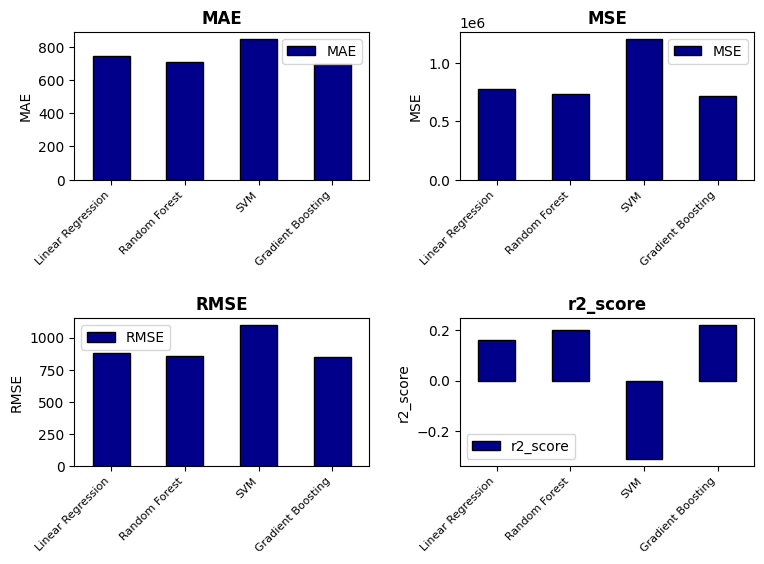

In [ ]:

metrics = ['MAE', 'MSE', 'RMSE', 'r2_score']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    result_table_holdout.plot(x='Algorithm Name', y=metric, kind='bar', ax=ax, width=0.5, color='darkblue', edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_xticklabels(result_table_holdout['Algorithm Name'], rotation=45, ha='right', fontsize=8)

plt.tight_layout(pad=2.0)

plt.show()



**Cross-validation k-fold method**

In [ ]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Initialize a list to store results
result_table_kfold = []

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a function to evaluate regression metrics including MDA
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Percentage error

    # Mean Directional Accuracy (MDA)
    mda = np.mean(np.sign(y_true - y_pred) == np.sign(y_true - np.mean(y_true))) * 100

    return mse, rmse, mae, r2, mape, mda

# Perform k-fold cross-validation for each model
for name, model in models.items():
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    mape_scores = []
    mda_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate metrics
        mse, rmse, mae, r2, mape, mda = evaluate_regression(y_test, y_pred)

        # Store scores for each fold
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mda_scores.append(mda)

    # Compute mean scores across folds
    mean_mse = np.mean(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)
    mean_r2 = np.mean(r2_scores)
    mean_mape = np.mean(mape_scores)
    mean_mda = np.mean(mda_scores)

    # Append results to the result_table_kfold
    result_table_kfold.append({
        'Algorithm Name': name,
        'Mean MAE': round(mean_mae, 2),
        'Mean MSE': round(mean_mse, 2),
        'Mean RMSE': round(mean_rmse, 2),
        'Mean r2_score': round(mean_r2, 2),
        'Mean MAPE': round(mean_mape, 2),
        'Mean MDA': round(mean_mda, 2)
    })

# Convert result_table_kfold to DataFrame
result_table_kfold = pd.DataFrame(result_table_kfold)

table = tabulate(result_table_kfold, headers='keys', tablefmt='pretty')
print(table)

+---+-------------------+----------+-----------+-----------+---------------+-----------+----------+
|   |  Algorithm Name   | Mean MAE | Mean MSE  | Mean RMSE | Mean r2_score | Mean MAPE | Mean MDA |
+---+-------------------+----------+-----------+-----------+---------------+-----------+----------+
| 0 | Linear Regression |  628.59  | 608998.94 |   777.2   |      0.1      |  393.32   |  80.75   |
| 1 |   Random Forest   |  636.67  | 631909.43 |  791.71   |     0.05      |  373.74   |  89.29   |
| 2 |        SVM        |  711.28  | 803512.47 |  883.13   |     -0.13     |  442.43   |  92.01   |
| 3 | Gradient Boosting |  657.8   | 713353.52 |  839.89   |     -0.09     |  371.39   |  86.59   |
+---+-------------------+----------+-----------+-----------+---------------+-----------+----------+


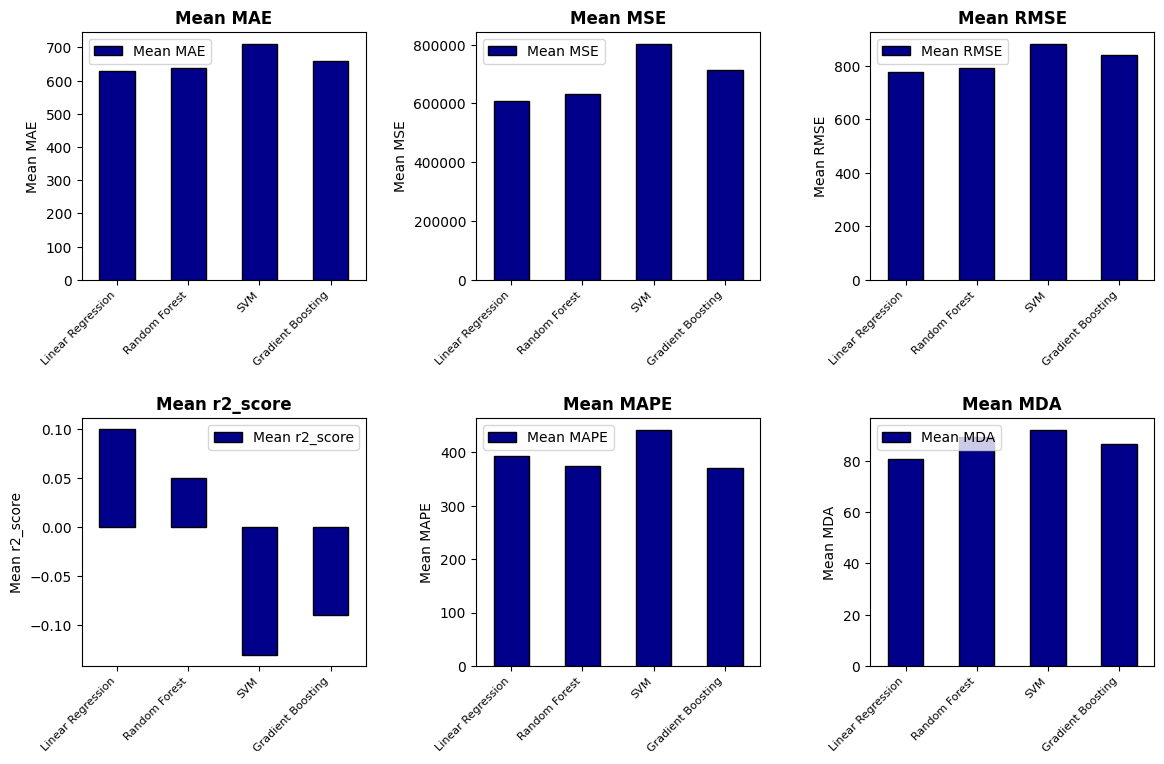

In [ ]:
metrics = ['Mean MAE', 'Mean MSE', 'Mean RMSE', 'Mean r2_score', 'Mean MAPE', 'Mean MDA']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]
    result_table_kfold.plot(x='Algorithm Name', y=metric, kind='bar', ax=ax, width=0.5, color='darkblue', edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_xticklabels(result_table_kfold['Algorithm Name'], rotation=45, ha='right', fontsize=8)

plt.tight_layout(pad=2.0)
plt.show()


**Cross-validation k-fold method and the algorithm run on the best parameter (hyper-parameter).**

In [ ]:
# Define a function for k-fold cross-validation with random search
def kfold_cross_validation(model, X, y, hyperparameters, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Setup random search cross-validation
        random_search = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters,
                                           n_iter=10, scoring='neg_mean_squared_error',
                                           cv=3, verbose=1, random_state=42)

        # Fit random search
        random_search.fit(X_train, y_train)

        # Predict on validation set
        y_pred = random_search.best_estimator_.predict(X_val)

        # Calculate evaluation metrics
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

        # Calculate MDA (Mean Directional Accuracy)
        mda = 100 * np.sum((y_pred[1:] - y_pred[:-1]) * (y_val[1:] - y_val[:-1]) > 0) / len(y_pred)

        results.append({
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape,
            'MDA': mda
        })

    # Calculate average metrics across all folds
    avg_results = {
        'MSE': np.mean([result['MSE'] for result in results]),
        'RMSE': np.mean([result['RMSE'] for result in results]),
        'MAE': np.mean([result['MAE'] for result in results]),
        'R2': np.mean([result['R2'] for result in results]),
        'MAPE': np.mean([result['MAPE'] for result in results]),
        'MDA': np.mean([result['MDA'] for result in results])
    }

    return avg_results

# Example data (replace with your data)
X = np.random.rand(100, 10)  # Example feature matrix
y = np.random.rand(100)     # Example target variable

# Define hyperparameters for each algorithm
linear_params = {}  # No hyperparameters for Linear Regression
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
svm_params = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': np.logspace(-3, 2, 6),
    'gamma': ['scale', 'auto']
}
gb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Perform k-fold cross-validation for each algorithm and store results
results = []
for name, model in models.items():
    if name == 'Linear Regression':
        hyperparams = linear_params
    elif name == 'Random Forest':
        hyperparams = rf_params
    elif name == 'SVM':
        hyperparams = svm_params
    elif name == 'Gradient Boosting':
        hyperparams = gb_params

    avg_results = kfold_cross_validation(model, X, y, hyperparams)
    avg_results['Algorithm Name'] = name
    results.append(avg_results)

# Convert results to DataFrame
result_df = pd.DataFrame(results)

In [ ]:
# Reorder columns as per the table format
result_df = result_df[['Algorithm Name', 'MAE', 'MSE', 'RMSE', 'R2', 'MAPE', 'MDA']]

# Add a column for Sno (Serial Number)
result_df.insert(0, 'Sno', range(1, len(result_df) + 1))

# Print the final table using tabulate
print("Table-3: Performance Metrics of Different Algorithms using k-fold Cross-Validation and Random Search")
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=False))

Table-3: Performance Metrics of Different Algorithms using k-fold Cross-Validation and Random Search
+-------+-------------------+----------+-----------+----------+-----------+---------+-------+
|   Sno | Algorithm Name    |      MAE |       MSE |     RMSE |        R2 |    MAPE |   MDA |
|-------+-------------------+----------+-----------+----------+-----------+---------+-------|
|     1 | Linear Regression | 0.25723  | 0.086564  | 0.292263 | -0.211202 | 144.833 |    55 |
|     2 | Random Forest     | 0.253961 | 0.0888207 | 0.296242 | -0.245992 | 148.225 |    52 |
|     3 | SVM               | 0.248658 | 0.0842868 | 0.288212 | -0.18019  | 162.915 |    51 |
|     4 | Gradient Boosting | 0.247993 | 0.0819664 | 0.284936 | -0.154519 | 152.323 |    47 |
+-------+-------------------+----------+-----------+----------+-----------+---------+-------+
